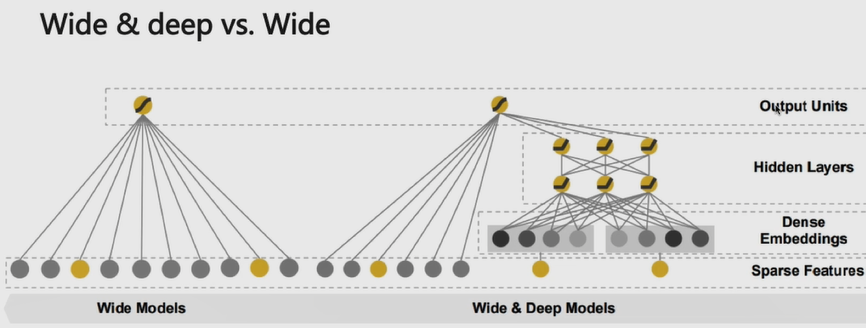

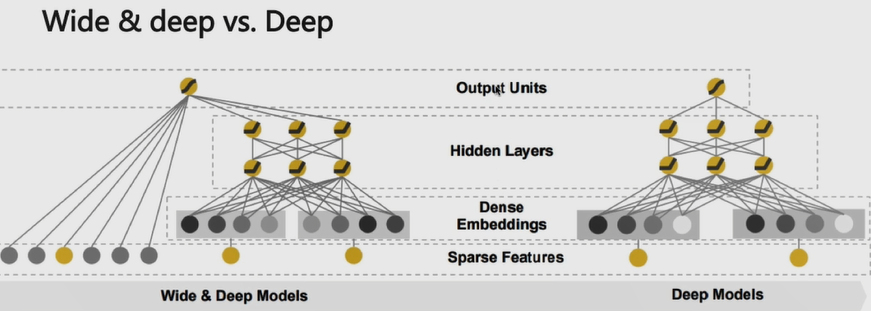

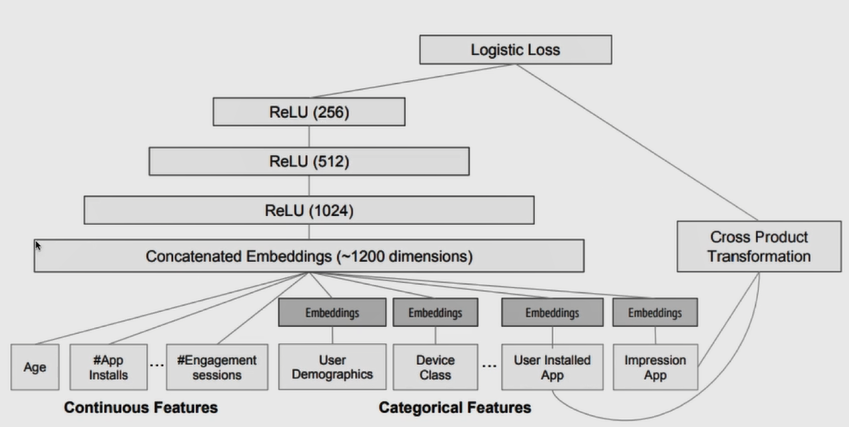

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import pandas as pd
import os, sys, time

import tensorflow as tf
from tensorflow import keras

%matplotlib inline

print(tf.__version__)
print(sys.version_info)

2.0.0
sys.version_info(major=3, minor=6, micro=8, releaselevel='final', serial=0)


In [2]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()
print(housing.DESCR)
print(housing.data.shape)
print(housing.target.shape)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bur

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

x_train_all, x_test, y_train_all,  y_test = train_test_split(
    housing.data, housing.target, random_state=1)
x_train, x_valid, y_train, y_test = train_test_split(
    x_train_all, y_train_all, random_state=2)

scaler = StandardScaler()
x_train_s = scaler.fit_transform(x_train)
x_valid_s = scaler.transform(x_valid)
x_test_s = scaler.transform(x_test)

### model

In [ ]:
# 函数式api
inputs_wide = keras.layers.Input(shape=[5])
inputs_deep = keras.layers.Input(shape=[6])
hidden1 = keras.layers.Dense(30, activation='selu')(inputs_deep)
hidden2 = keras.layers.Dense(30, activation='selu')(hidden1)

concat = keras.layers.concatenate([inputs_wide, hidden2])
output = keras.layers.Dense(1)(concat)
output_2 = keras.layers.Dense(1)(hidden2)

model = keras.models.Model(inputs=[inputs_wide, inputs_deep], 
                                                   outputs=[output, output_2])

In [ ]:
# # 子类api(和函数式api，二者选择其一运行）
# class WideDeepModel(keras.models.Model):
#     def __init__(self):
#         super(WideDeepModel, self).__init__()
#         self.hidden1_layer = keras.layers.Dense(30, activation='selu')
#         self.hidden2_layer = keras.layers.Dense(30, activation='selu')
#         self.output_layer = keras.layers.Dense(1)
        
#     def call(self, inputs):
#         hidden1 = self.hidden1_layer(inputs)
#         hidden2 = self.hidden2_layer(hidden1)
#         concat = keras.layers.concatenate([inputs, hidden2])
#         output = self.output_layer(concat)
        
        
# model = WideDeepModel()
# model.build(input_shape=(None, 8))

In [ ]:
model.compile(loss='mean_squared_error',
              optimizer='sgd')

# model.layers
model.summary()

callbacks = [
    keras.callbacks.EarlyStopping(patience=5, min_delta=1e-3)
]

history = model.fit([x_train_s[:, : 5], x_train_s[:, 2: ]],
                                [y_train, y_train],
                                validation_data=([x_valid_s[:, : 5], x_valid_s[:, 2: ]], [y_valid, y_valid]), 
                                epochs=100,
                                callbacks=callbacks)

In [ ]:
def plot_learning_curve(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()

plot_learning_curve(history)

#### sklearn wrapper

In [ ]:
def build_model_sklearn(learning_rate=3e-3):
    optimizer = keras.optimizers.SGD(learning_rate)
    model.compile(loss='mean_squared_error',
              optimizer=optimizer)
    return model

sklearn_model = keras.wrappers.scikit_learn.KerasRegressor(build_model_sklearn)
sklearn_model.fit([x_train_s[:, : 5], x_train_s[:, 2: ]],
                                [y_train, y_train],
                                validation_data=([x_valid_s[:, : 5], x_valid_s[:, 2: ]], [y_valid, y_valid]), 
                                epochs=100,
                                callbacks=callbacks)

In [ ]:
from scipy.stats import reciprocal

# 随机搜索
param_dist = {
    "learning_rate": reciprocal(1e-4, 1e-2)
}

from sklearn.model_selection import RandomizedSearchCV

random_search = RandomizedSearchCV(sklearn_model,
                                                                  param_dist,
                                                                  n_iter=10,
                                                                  n_jobs=1)

random_search.fit([x_train_s[:, : 5], x_train_s[:, 2: ]],
                                [y_train, y_train],
                                validation_data=([x_valid_s[:, : 5], x_valid_s[:, 2: ]], [y_valid, y_valid]), 
                                epochs=100,
                                callbacks=callbacks)

### 超参数搜索

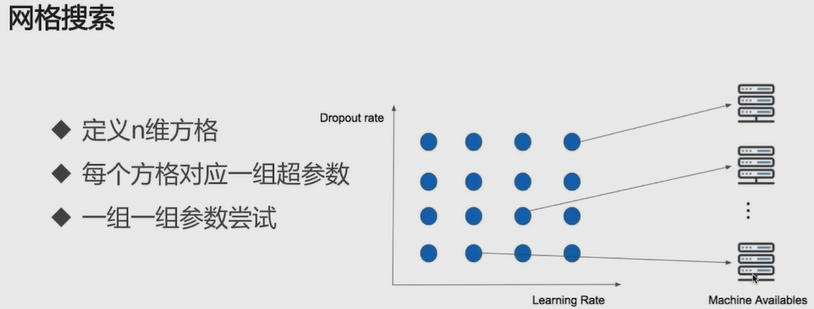

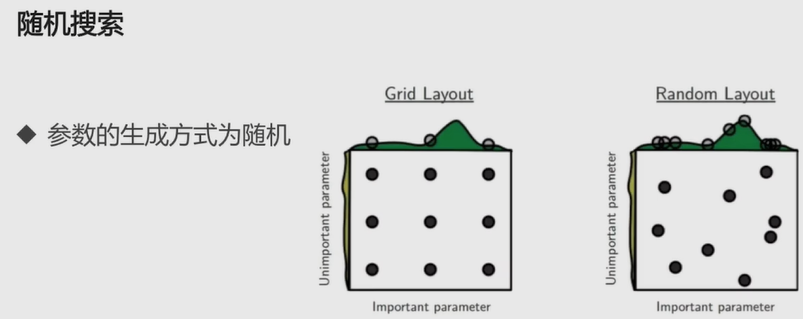

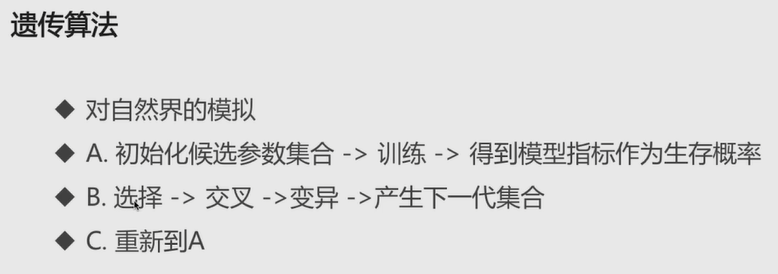

训练结果 -> 多组参数的生成概率 -> 多组参数选择交叉变异 -> 生成下一代参数 -> 再训练

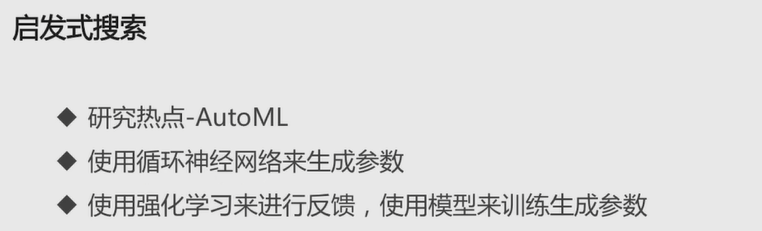